In [41]:
import pandas as pd

import numpy as np
import sys, os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib

matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2.5
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [42]:
# function to change boxplot width
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # change the bar width
        patch.set_width(new_value)
        # recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

## Figure 2A: Location and usage frequency of donors

In [43]:
# import splicing data
hela = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')

# rename donor to GFP, alt-GFP, PRE, or others
def rename_donor(isoform):
    if isoform == 'full_length':
        return np.nan, np.nan
    elif 'GTACAA_132' in isoform:
        return 'GFP', 132
    elif 'CGAGCT_126' in isoform:
        return 'alt-GFP', 126
    elif 'CGACTT_171' in isoform:
        return 'PRE', 171
    elif 'CGACTT_204' in isoform:
        return 'PRE', 204
    else:
        return 'others', float(isoform.split('_')[1])
    
hela['donor_name'], hela['donor_pos'] = zip(*hela['best_category'].apply(lambda g: rename_donor(g)))

In [44]:
# For each reporter, group together the same donor and add the splicing fraction to get donor usage
grouped_donor = hela.groupby(['donor_name', 'donor_pos'])['fraction'].sum().reset_index()

min_idx = 100
max_idx = 350 # end of barcode position

for i in range(min_idx, max_idx):
    if float(i) not in grouped_donor['donor_pos'].to_list():
        grouped_donor = pd.concat(
            [grouped_donor,
            pd.DataFrame(data = {'donor_name': ['n/a'], 'donor_pos': [i], 'fraction': [0]})]
        )

grouped_donor = grouped_donor.sort_values(by = 'donor_pos')

# list of colors
color_dict = {'GFP': 'green', 'PRE': 'yellow', 'alt-GFP': 'blue', 'others': 'grey', 'n/a': 'grey'}
grouped_donor['color'] = grouped_donor['donor_name'].apply(lambda g: color_dict[g])

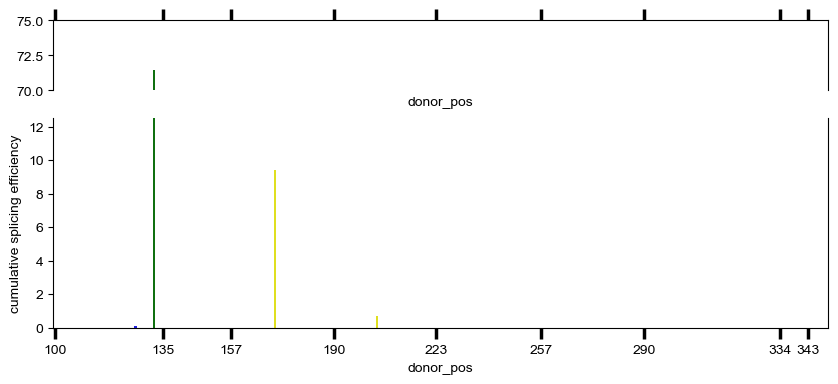

In [45]:
# Plot donor usage by location 
f, (ax1, ax2) = plt.subplots(
    nrows = 2, 
    figsize = (10, 4), 
    sharex = True, 
    gridspec_kw={'height_ratios': [1, 3]}
)

sns.barplot(
    data = grouped_donor, 
    x = 'donor_pos', 
    y = 'fraction', 
    palette = grouped_donor['color'],
    ax = ax1
)

sns.barplot(
    data = grouped_donor, 
    x = 'donor_pos', 
    y = 'fraction', 
    palette = grouped_donor['color'],
    ax = ax2
)

ax1.set_ylabel('')
ax2.set_ylabel('cumulative splicing efficiency')

ax1.set_ylim(70, 75)
ax2.set_ylim(-0.05, 12.5)

ax2.set_xticks([0, 35, 57, 90, 123, 157, 190, 234, 243])
ax2.set_xticklabels([100, 135, 157, 190, 223, 257, 290, 334, 343])

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

f.savefig('PLOTS/Fig_2A.pdf', transparent = True)

## Figure 2B: PTRE-seq donors compared to human annotated donors

In [7]:
# Retrieve MaxEnt score for all human splice donor
fns = ['human_CDS_5ss_MAXENT.txt', 'human_3UTR_5ss_MAXENT.txt', 'human_5UTR_5ss_MAXENT.txt']
scores = []

for fn in fns:
    with open(f'data/{fn}', 'r') as f:
        for line in f:
            if 'MAXENT' in line:
                spl = line.rstrip().split(' ')
                score = float(spl[1])
                scores.append(score)

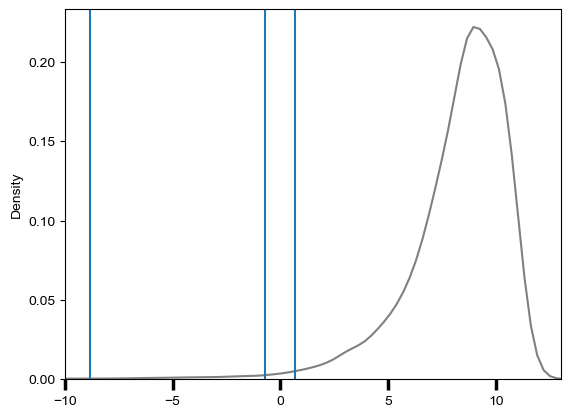

In [9]:
f, ax = plt.subplots()

sns.kdeplot(x = scores, ax = ax, color = 'grey', bw_adjust = 3)

ax.axvline(0.66) # GFP donor maxent score
ax.axvline(-0.73) # PRE donor maxent score
ax.axvline(-8.82) # alt-GFP donor maxent score

ax.set_xlim(-10, 13)

f.savefig('PLOTS/Fig_2B.pdf', transparent = True)

## Figure 2D: Location and usage frequency of acceptors

In [46]:
def get_acceptor_loc(RE, isoform):
    # function to retrieve name and location of acceptor
    if isoform == 'full_length':
        return np.nan, np.nan
    else:
        spl = isoform.split('_')
        loc = float(spl[3])
        acc = 'other'
        
        if len(RE) == 4 and RE != 'Dna2':
            if 157 < loc < 190:
                acc = RE[0]
            elif 190 < loc < 223:
                acc = RE[1]
            elif 223 < loc < 256:
                acc = RE[2]
            elif 256 < loc < 290:
                acc = RE[3]
            elif 290 < loc < 334:
                acc = 'spacer'
            
        return acc, loc
    
        
hela['acceptor_name'], hela['acceptor_pos'] = zip(*hela.apply(
    lambda g: get_acceptor_loc(g['RE'], g['best_category']), axis = 1)
                                                 )

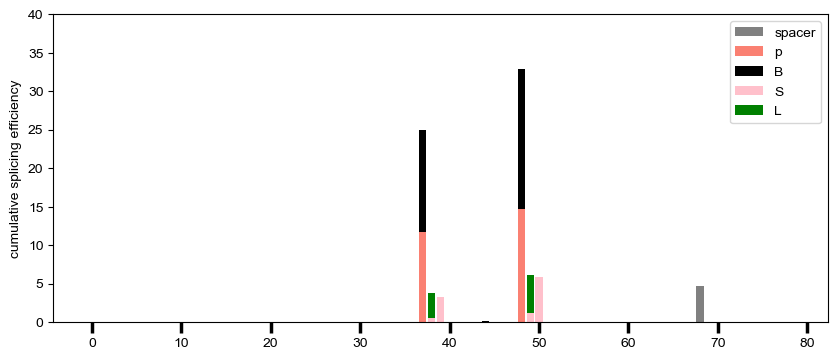

In [47]:
# Plot acceptor usage by location 
f, ax = plt.subplots(figsize = (10, 4))

min_idx = 115
max_idx = 352 # end of barcode position
grouped_acceptor = hela.groupby(['acceptor_name', 'acceptor_pos'])['fraction'].sum().reset_index()
bottom = np.array([0.0]*79)

for acceptor, color in zip(['spacer', 'p', 'B', 'S', 'L'], ['grey', 'salmon', 'black', 'pink', 'green']):
    _grouped_acceptor = grouped_acceptor[grouped_acceptor['acceptor_name']==acceptor]

    for i in range(min_idx, max_idx):
        if float(i) not in _grouped_acceptor['acceptor_pos'].to_list():
            _grouped_acceptor = pd.concat(
                [_grouped_acceptor,
                pd.DataFrame({'acceptor_name': ['n/a'], 'acceptor_pos': [i], 'fraction': [0]})]
            )
            
    _grouped_acceptor = _grouped_acceptor.sort_values(by = 'acceptor_pos')   
    
    _grouped_acceptor['new_idx'] = [i for i in range(int(len(_grouped_acceptor)/3)) for _ in range(3)]
    _grouped_acceptor = _grouped_acceptor.groupby('new_idx')['fraction'].sum().to_frame().reset_index()
    
    ax.bar(
        x = _grouped_acceptor['new_idx'].to_list(),
        height = _grouped_acceptor['fraction'].to_list(), 
        label = acceptor, 
        color = color,
        bottom = bottom,
    )
    
    bottom += _grouped_acceptor['fraction']

ax.set_ylabel('cumulative splicing efficiency')
ax.set_ylim(0, 40)

ax.legend()

f.savefig('PLOTS/Fig_2D.pdf', transparent = True)

## Figure 2E: PTRE-seq acceptors vs human annotated acceptors

In [13]:
# Retrieve MaxEnt score for all human splice donor
fns = ['human_CDS_3ss_MAXENT.txt', 'human_3UTR_3ss_MAXENT.txt', 'human_5UTR_3ss_MAXENT.txt']
scores = []

for fn in fns:
    with open(f'data/{fn}', 'r') as f:
        for line in f:
            if 'MAXENT' in line:
                spl = line.rstrip().split(' ')
                score = float(spl[1])
                scores.append(score)

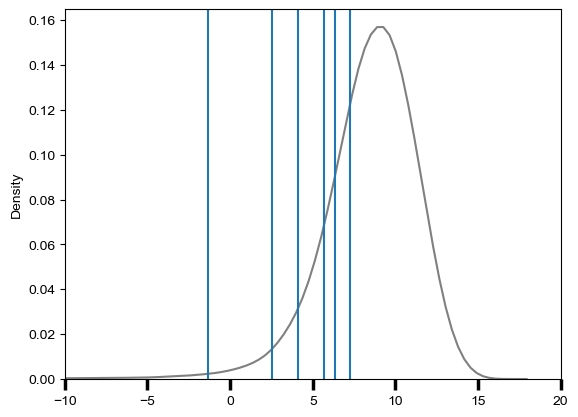

In [15]:
f, ax = plt.subplots()

sns.kdeplot(x = scores, ax = ax, color = 'grey', bw_adjust = 3)

ax.axvline(7.22) # space acceptor MaxEnt score
ax.axvline(6.32) # PRE acceptor MaxEnt score
ax.axvline(5.66) # Blank acceptor MaxEnt score
ax.axvline(4.08) # SRE2 acceptor MaxEnt score
ax.axvline(2.56) # SRE1 acceptor MaxEnt score
ax.axvline(-1.33) # Let-7 acceptor MaxEnt score

ax.set_xlim(-10, 20)

f.savefig('PLOTS/Fig_2E.pdf', transparent = True)

## Figure S2B: Single reporter validation

In [16]:
# western plot quantification
western = pd.read_excel(
    'data/single_reporter_validation_quantification.xlsx', 
    sheet_name = 'Westernblot', engine = 'openpyxl'
)
western['1-f'] = western.groupby(['Replicate', 'RE'])['norm_exp'].apply(lambda g: g/g.sum())
western['f'] = 1 - western['1-f']
western['sample'] = 'protein'
protein = western[western['Isoform']=='FL']

# sequencing quantification
mRNA = hela[hela['best_category']=='full_length'].reset_index(drop = True)
mRNA['f'] = 1 - mRNA['fraction']
mRNA['sample'] = 'RNA'

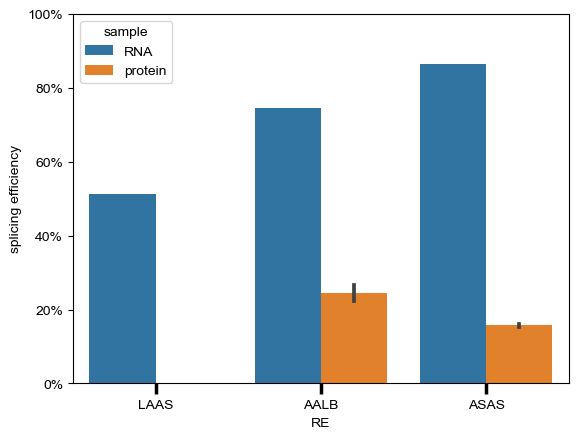

In [18]:
toplot = pd.concat([mRNA[['RE', 'f', 'sample']], protein[['RE', 'f', 'sample']]])

f, ax = plt.subplots()

sns.barplot(
    data = toplot, 
    x = 'RE', 
    y = 'f', 
    hue = 'sample', 
    order = ['LAAS', 'AALB', 'ASAS'],
    ax = ax
)

change_width(f, 0.1)


ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
ax.set_ylabel('splicing efficiency')

f.savefig('PLOTS/Fig_S3B.pdf', transparent = True)

## Figure S2C: donor usage

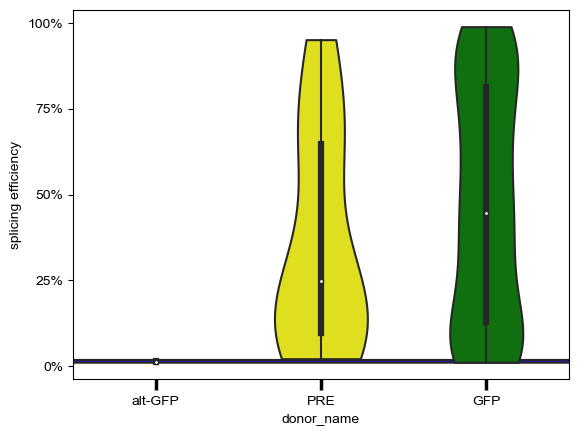

In [20]:
f, ax = plt.subplots()

toplot1 = hela[hela['fraction']>0.01] # exclude reporters less than 1% spliced
# group usage by donor (if a reporter has 2 spliced isoforms that use the same donor then sum the fraction)
toplot1 = toplot1.groupby(['RE', 'donor_name'])['fraction'].sum().to_frame().reset_index()

sns.violinplot(
    data = toplot1, 
    x = 'donor_name', 
    y = 'fraction', 
    order = ['alt-GFP', 'PRE', 'GFP'],
    palette = ['blue', 'yellow', 'green'],
    width = 35,
    cut = 0,
    ax = ax)

ax.set_yticks([0.0, 0.25, 0.50, 0.75, 1.0])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_ylabel('splicing efficiency')

f.savefig('PLOTS/Fig_S3C.pdf', transparent = True)

## Figure S3D: PRE vs GFP donor usage

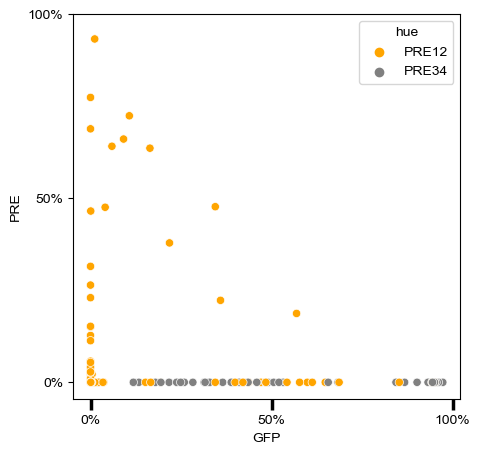

In [22]:
# filter for reporter with 1 or more PRE
pre_reporter = hela[
    (hela['RE'].str.contains('p'))&
    (hela['RE'].str.contains('^[BLpSA]{4}$'))&
    (hela['fraction']>0)
]

# covert to wide dataframe
pre_reporter_wide = pd.pivot_table(
    pre_reporter, index = 'RE', values = 'fraction', columns = 'donor_name', fill_value = 0
).reset_index()

def make_hue(p):
    if 'p' not in p:
        return 'PRE0'
    elif p[0] == 'p' or p[1] == 'p':
        return 'PRE12'
    else:
        return 'PRE34'

# flag if PRE is in 1st/2nd position VS 3rd/4th position
pre_reporter_wide['hue'] = pre_reporter_wide.apply(lambda g: make_hue(g['RE']), axis = 1)

# scatterplot comparing PRE and GFP donor
f, ax = plt.subplots(figsize = (5, 5))

sns.scatterplot(
    data = pre_reporter_wide, 
    x = 'GFP', 
    y = 'PRE', 
    hue = 'hue', 
    hue_order = ['PRE12', 'PRE34'],
    palette = ['orange', 'grey'],
    ax = ax
)

ax.set_xticks([0, 0.5, 1.0])
ax.set_xticklabels(['0%', '50%', '100%'])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0%', '50%', '100%'])

f.savefig('PLOTS/Fig_S3D.pdf')

## Figure S3E: acceptor usage

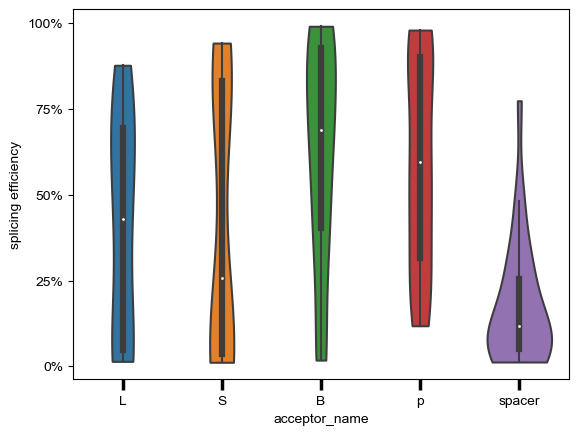

In [27]:
f, ax = plt.subplots()

toplot1 = hela[hela['fraction']>0.01] # exclude reporters less than 1% spliced
# group usage by acceptor (if a reporter has 2 spliced isoforms that use the same acceptor then sum the fraction)
toplot1 = toplot1.groupby(['RE', 'acceptor_name'])['fraction'].sum().to_frame().reset_index()

sns.violinplot(
    data = toplot1, 
    x = 'acceptor_name', 
    y = 'fraction', 
    order = ['L', 'S', 'B', 'p', 'spacer'],
    width = 0.65,
    cut = 0,
    ax = ax)


ax.set_yticks([0.0, 0.25, 0.50, 0.75, 1.0])
ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_ylabel('splicing efficiency')

#ax.legend(bbox_to_anchor = (1, 1))

f.savefig('PLOTS/Fig_S3E.pdf', transparent = True)

## Figure S2F: distribution of intron length

In [28]:
HELA = pd.read_csv('ptreseq_splicing_quantification/HELA_2rep_fraction.txt', sep = '\t')
HELA_long = HELA[HELA['fraction']!=0]

def intron_length(c):
    if c == 'full_length':
        return np.nan
    else:
        _, start, _, end = c.split('_')
        return int(end) - int(start) + 1
    
HELA_long['intron_len'] = HELA_long['best_category'].apply(lambda g: intron_length(g))

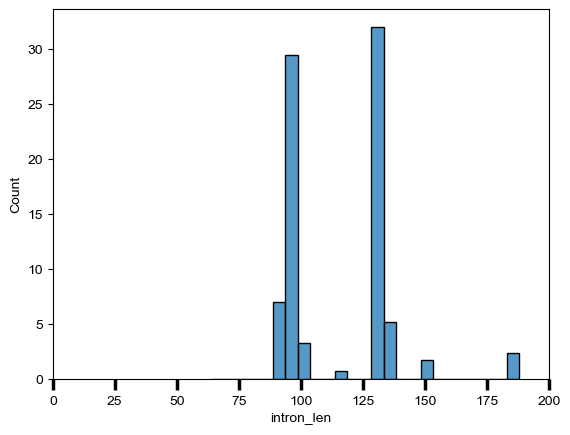

In [30]:
f, ax = plt.subplots()

sns.histplot(
    data = HELA_long, 
    x = 'intron_len',
    weights = 'fraction', 
    stat = 'count',
    bins = 25, 
    ax = ax
)

ax.set_xlim(0, 200)

f.savefig('PLOTS/Fig_S3F.pdf', transparent = True)